In [1]:
import os.path
from typing import Any, Callable, List, Optional, Tuple

from PIL import Image
from torchvision.datasets import VisionDataset
import numpy as np
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
class CocoDetection(VisionDataset):
    def __init__(
        self,
        root: str,
        annFile: str,
        class_names: Optional[List] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transforms, transform, target_transform)
        from pycocotools.coco import COCO

        self.coco = COCO(annFile)

        if class_names is not None:
            cat_ids = self._get_category_ids_from_name(category_names=class_names)
            self.ids = list(
                sorted((self._get_img_ids_for_category_ids(category_ids=cat_ids)))
            )

        else:
            cat_ids = self.coco.getCatIds()
            self.ids = list(sorted(self.coco.imgs.keys()))

        self.cat2idx = {cat_id: idx + 1 for idx, cat_id in enumerate(cat_ids)}
        self.cat2idx[0] = 0

    def _load_image(self, id: int) -> Image.Image:
        path = self.coco.loadImgs(id)[0]["file_name"]
        return Image.open(os.path.join(self.root, path)).convert("RGB")

    def _load_target(self, id: int) -> List[Any]:
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        id = self.ids[index]
        image = self._load_image(id)
        mask = self._load_target(id)

        mask = self._get_mask_in_channels(image, mask)

        if self.transform is not None:
            image = self.transform(image=np.array(image))["image"]

        if self.target_transform is not None:
            mask = self.target_transform(image=mask)["image"]

        return image, (mask != 0).int()

    def __len__(self) -> int:
        return len(self.ids)

    def _get_all_classes(self):
        catIDs = self.coco.getCatIds()
        return self.coco.loadCats(catIDs)

    def _get_category_info_from_ids(self, ids: list):
        all_cat = self._get_all_classes()
        return [category for category in all_cat if category["id"] in ids]

    def _get_category_ids_from_name(self, category_names: list):
        return self.coco.getCatIds(catNms=category_names)

    def _get_img_ids_for_category_ids(self, category_ids: list):
        img_ids = []

        for catIds in category_ids:
            img_ids.extend(self.coco.getImgIds(catIds=catIds))

        return img_ids

    def _get_img_ids_for_category_names(self, category_names: list):
        img_ids = []
        category_ids = self._get_category_ids_from_name(category_names=class_names)

        for catIds in category_ids:
            img_ids.extend(self.coco.getImgIds(catIds=catIds))

        return img_ids

    def _get_all_category_ids_in_img_id(self, img_id: int) -> List:
        target = self._load_target(img_id)
        return list({annotation["category_id"] for annotation in target})

    def _get_mask_aggregated(self, image: Image, annotations: List) -> np.array:
        w, h = image.size
        mask = np.zeros((h, w))

        for annotation in annotations:
            category_id = annotation["category_id"]

            if category_id in self.cat2idx:
                pixel_value = self.cat2idx[category_id]
                mask = np.maximum(self.coco.annToMask(annotation) * pixel_value, mask)

        return mask

    def _get_mask_in_channels(self, image: Image, annotations: List) -> np.array:
        w, h = image.size
        mask = np.zeros((len(self.cat2idx), h, w))

        for annotation in annotations:
            category_id = annotation["category_id"]

            if category_id in self.cat2idx:
                pixel_value = self.cat2idx[category_id]
                mask[pixel_value] = np.maximum(
                    self.coco.annToMask(annotation), mask[pixel_value]
                )

        # [h, w, channels]
        mask = np.transpose(mask, (1, 2, 0))
        return mask

    def _plot_image_and_mask(self, index):
        image, mask = self[index]

        # Create a figure with two subplots side by side
        fig, axs = plt.subplots(1, 2, figsize=(7, 3))

        axs[0].imshow(image.permute(1, 2, 0))
        axs[0].set_title("Image")

        axs[1].imshow(mask.sum(0, keepdim=True).permute(1, 2, 0))
        axs[1].set_title("Mask")

        plt.show()

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


transform = A.Compose([A.Resize(512, 512), ToTensorV2()])

train_dataset = CocoDetection(
    root="./data/train/data",
    annFile="./data/raw/instances_train2017.json",
    transform=transform,
    target_transform=transform,
)
test_dataset = CocoDetection(
    root="./data/validation/data",
    annFile="./data/raw/instances_val2017.json",
    transform=transform,
    target_transform=transform,
)

loading annotations into memory...
Done (t=22.50s)
creating index...
index created!
loading annotations into memory...
Done (t=0.79s)
creating index...
index created!


In [4]:
img_idx = 1

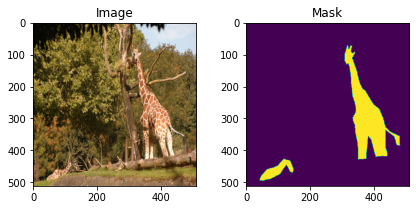

In [5]:
train_dataset._plot_image_and_mask(img_idx)

In [6]:
img, mask = train_dataset[img_idx]
img.shape, type(img), mask.shape, type(mask)

(torch.Size([3, 512, 512]),
 torch.Tensor,
 torch.Size([81, 512, 512]),
 torch.Tensor)

In [7]:
cat_ids = train_dataset._get_all_category_ids_in_img_id(train_dataset.ids[img_idx])

In [8]:
train_dataset._get_category_info_from_ids(cat_ids)

[{'supercategory': 'animal', 'id': 25, 'name': 'giraffe'}]

# Download Dataset

In [ ]:
# # download Coco dataset
# import fiftyone.zoo as foz


# foz.load_zoo_dataset(
#     "coco-2017",
#     split="train",
#     label_types=["segmentations"],
#     max_samples=5,
#     dataset_dir="./data",
# )

# foz.load_zoo_dataset(
#     "coco-2017",
#     split="validation",
#     label_types=["segmentations"],
#     max_samples=5,
#     dataset_dir="./data",
# )